# Semantic Segmentation Lab - VGG16-UNET Version

This is variation of original Lab with more recent segmentation model.

## Data Collection<a id='data'></a>
We have provided you with the dataset for this lab. If you haven't already downloaded the training and validation datasets, you can check out the README for this lab's repo for instructions as well.

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

import keras
from keras import layers, models

from utils import scoring_utils
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

Using TensorFlow backend.


### Model

In [2]:
def vgg16_unet(input_shape=(256,256,3), weights='imagenet'):
    vgg16_model = keras.applications.VGG16(input_shape=input_shape, weights=weights, include_top=False)

    block4_pool = vgg16_model.get_layer('block4_pool').output
    block5_conv1 =  layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(block4_pool)
    block5_conv2 =  layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(block5_conv1)
    block5_drop = layers.Dropout(0.5)(block5_conv2)

    block6_up = layers.Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        layers.UpSampling2D(size=(2, 2))(block5_drop))
    block6_merge = layers.Concatenate(axis=3)([vgg16_model.get_layer('block4_conv3').output, block6_up])
    block6_conv1 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(block6_merge)
    block6_conv2 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(block6_conv1)
    block6_conv3 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(block6_conv2)


    block7_up = layers.Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        layers.UpSampling2D(size=(2, 2))(block6_conv3))
    block7_merge = layers.Concatenate(axis=3)([vgg16_model.get_layer('block3_conv3').output, block7_up])
    block7_conv1 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(block7_merge)
    block7_conv2 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(block7_conv1)
    block7_conv3 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(block7_conv2)


    block8_up = layers.Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        layers.UpSampling2D(size=(2, 2))(block7_conv3))
    block8_merge = layers.Concatenate(axis=3)([vgg16_model.get_layer('block2_conv2').output, block8_up])
    block8_conv1 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(block8_merge)
    block8_conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(block8_conv1)

    block9_up = layers.Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        layers.UpSampling2D(size=(2, 2))(block8_conv2))
    block9_merge = layers.Concatenate(axis=3)([vgg16_model.get_layer('block1_conv2').output, block9_up])
    block9_conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(block9_merge)
    block9_conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(block9_conv1)

    block10_conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(block9_conv2)
    block10_conv2 = layers.Conv2D(3, 1, activation='sigmoid')(block10_conv1)

    model = models.Model(inputs=vgg16_model.input, outputs=block10_conv2)
    return model

In [3]:
image_hw = 224
image_shape = (image_hw, image_hw, 3)

model = vgg16_unet(image_shape)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


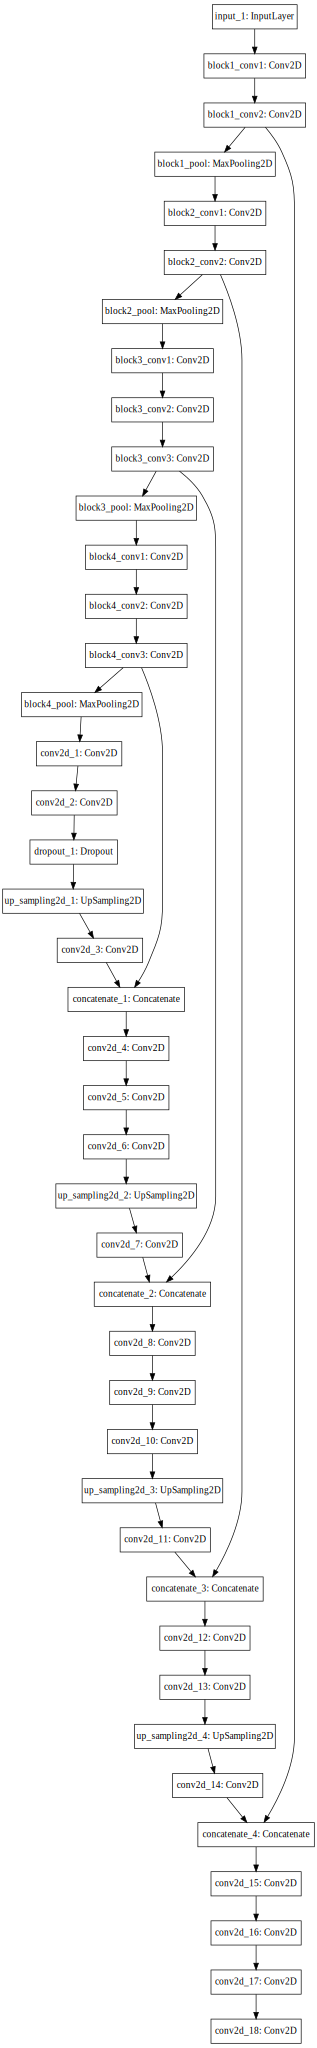

In [4]:
from IPython.display import SVG

SVG(keras.utils.vis_utils.model_to_dot(model).create(prog='dot', format='svg'))

## Training

In [5]:
inputs = layers.Input(image_shape)
num_classes = 3

### Hyperparameters

In [6]:
learning_rate = 1e-4
batch_size = 4
num_epochs = 10
validation_steps = 50
steps_per_epoch = 200

In [7]:
# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train', 'train_combined'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

In [8]:
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = 50, # the number of batches to validate on
                    workers = 2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
200/200 [==============================] - 60s 298ms/step - loss: 0.0502 - acc: 0.9859 - val_loss: 0.0463 - val_acc: 0.9834
Epoch 2/10
200/200 [==============================] - 54s 268ms/step - loss: 0.0404 - acc: 0.9860 - val_loss: 0.0426 - val_acc: 0.9859
Epoch 3/10
200/200 [==============================] - 53s 267ms/step - loss: 0.0319 - acc: 0.9877 - val_loss: 0.0402 - val_acc: 0.9854
Epoch 4/10
200/200 [==============================] - 54s 268ms/step - loss: 0.0259 - acc: 0.9900 - val_loss: 0.0285 - val_acc: 0.9907
Epoch 5/10
200/200 [==============================] - 53s 266ms/step - loss: 0.0302 - acc: 0.9867 - val_loss: 0.0776 - val_acc: 0.9795
Epoch 6/10
200/200 [==============================] - 56s 278ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 0.0476 - val_acc: 0.9811
Epoch 7/10
200/200 [==============================] - 54s 269ms/step - loss: 0.0216 - acc: 0.9885 - val_loss: 0.0301 - val_acc: 0.9853
Epoch 8

In [15]:
# Save your trained model weights
weight_file_name = 'vgg16_unet'
model_tools.save_network(model, weight_file_name)

## Prediction<a id='prediction'></a>

In [16]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

In [17]:
# generate predictions, save in the runs, directory.
run_number = 'vgg16_unet'
validation_path, output_path = model_tools.write_predictions_grade_set(model,run_number,'validation')

D:\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  
D:\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # This is added back by InteractiveShellApp.init_path()
D:\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if sys.path[0] == '':
D:\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be 

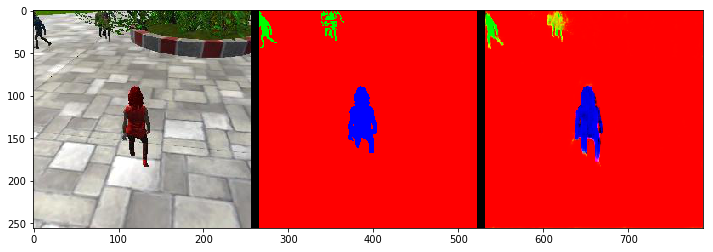

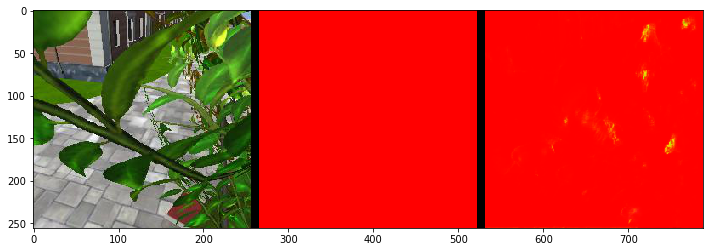

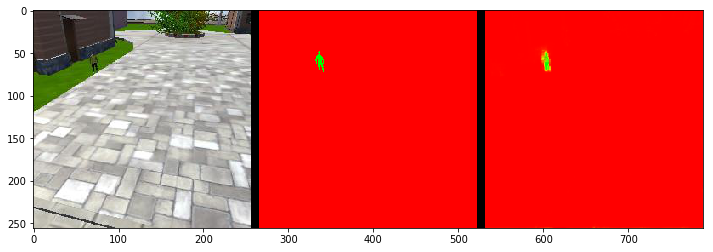

In [18]:
from utils import plotting_tools
from scipy import misc

im_files = plotting_tools.get_im_file_sample(run_number, validation_path)
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    image = im_tuple[0]
    image = misc.imresize(image, image_shape)
    image = data_iterator.preprocess_input(image.astype(np.float32))
    predicted = model.predict(np.array([image]))
    predicted = misc.toimage(predicted[0])
    predicted = misc.imresize(misc.toimage(predicted), (256, 256), interp='nearest')
    im_tuple = im_tuple + (predicted,)
    plotting_tools.show_images(im_tuple)

## Evaluation<a id='evaluation'></a>
Let's evaluate your model!

In [19]:
scoring_utils.score_run(validation_path, output_path)

number of validation samples intersection over the union evaulated on 1184
average intersection over union for background is 0.9910767980300638
average intersection over union for other people is 0.4067272314461133
average intersection over union for hero is 0.15575457082402383
global average intersection over union is 0.5178528667667336
